# ECE421 Assignment 1

Data Imports from the Starter Code

In [27]:
import numpy as np
def loadData():
    with np.load('notMNIST.npz') as data :
        Data, Target = data ['images'], data['labels']
        posClass = 2
        negClass = 9
        dataIndx = (Target==posClass) + (Target==negClass)
        Data = Data[dataIndx]/255.
        Target = Target[dataIndx].reshape(-1, 1)
        Target[Target==posClass] = 1
        Target[Target==negClass] = 0
        np.random.seed(421)
        randIndx = np.arange(len(Data))
        np.random.shuffle(randIndx)
        Data, Target = Data[randIndx], Target[randIndx]
        trainData, trainTarget = Data[:3500], Target[:3500]
        validData, validTarget = Data[3500:3600], Target[3500:3600]
        testData, testTarget = Data[3600:], Target[3600:]
    return trainData, validData, testData, trainTarget, validTarget, testTarget

trainData, validData, testData, trainTarget, validTarget, testTarget = loadData()

# Training Data
X_train = np.reshape(trainData, (3500,784))
Y_train = np.array(trainTarget)

# Test Data
X_test = np.reshape(testData, (145,784))
Y_test = np.array(testTarget)

# Validation Data
X_validation = np.reshape(validData, (100,784))
Y_validation = np.array(validTarget)

# Initial values
W_initial = np.zeros([784, 1])
b_initial = 0
reg_param = 0

## 1. Linear Regression

### 1. Loss Function and Gradient

#### Derivation
Let B be the vector $(b ... b)^{T}$, Y be the vector $(y_{1} ... y_{n})^{T}$, and X be the matrix
$\begin{pmatrix}
           x_{11} & \dots & x_{1d} \\
           \vdots & \ddots & \vdots\\
           x_{n1} & \dots & x_{nd}
\end{pmatrix}$ i.e. $ X= (x_{1}^{T} \dots x_{n}^{T})$<br>
__MSE Calculation & Vectorization__<br>
\begin{equation*}
L = L_{D} + L_{W} \\
L = \sum_{n=1}^{N}\frac1N\lvert\lvert W^{T}x^{(n)} + b - y^{(n)}\rvert\rvert_{2}^{2} + \frac\lambda2\lvert\lvert W\rvert\rvert_{2}^{2}\\
L = \frac1N\lvert\lvert W^{T}X + B - Y\rvert\rvert_{2}^{2} + \frac\lambda2\lvert\lvert W\rvert\rvert_{2}^{2}
\end{equation*}
<br>
** Note: since $W^{T}X + B - Y$ produces a scalar quantity, the L2 norm is equivalent to squaring this quantity.

__Grad MSE__<br>
\begin{equation*}
L = L_{D} + L_{W} \\
where\ L_{D} = \sum_{n=1}^{N}\frac1N\lvert\lvert W^{T}x^{(n)} + b - y^{(n)}\rvert\rvert_{2}^{2}\ and\  L_{W}\frac\lambda2\lvert\lvert W\rvert\rvert_{2}^{2}\\
By\ inspection, \frac{\partial L_w}{\partial b} = 0, \frac{\partial L_w}{\partial w} = \lambda w. \\
\end{equation*}
\begin{align*}
L_{D} &= \frac{1}{N}(W^TX + B - Y)^T(W^TX + B - Y) \\
Let\ L_{D}^{'} &= NL_{D}\ and\ V = W^TX \implies V^T = X^TW \\
i.e.\ L_D{'} &= (V + B - Y)^T(V+B-Y) \\
&= V^TV + V^TB - Y^TB + B^TV + B^TB + B^TY - Y^TV - Y^TB -Y^TY \\
&= \lvert\lvert V \rvert\rvert^2 - 2V^TY - 2B^TY + 2V^TB - \lvert\lvert Y \rvert\rvert^2 + \lvert\lvert B \rvert\rvert^2
\end{align*}
\begin{align*}
thus,\ \frac{\partial L_D^{'}}{\partial B} &= -2Y + 2V +2B \\
\implies \frac{\partial L_D}{\partial B} &= \frac{2}{N}(W^TX + B - Y)\\
and\ \frac{\partial L_D^{'}}{\partial W} &= \frac{\partial}{\partial W}\left[ \lvert\lvert W^TX \rvert\rvert^2 - 2(W^TX)^TY + 2(W^TX)^TB \right] \\
\implies \frac{\partial L_D}{\partial W} &= \frac{2}{N}\left[ W^TX + (B - Y) \right]X^T
\end{align*}
Finally, combining all the intermediate calculations above, we obtain:
\begin{align*}
\frac{\partial L_D}{\partial W} &= \frac{2}{N}( W^TX + B - Y)X^T + \lambda W\\
\frac{\partial L_D}{\partial B} &= \frac{2}{N}(W^TX + B - Y)
\end{align*}
<br>

In [28]:
import numpy as np

def MSE(W, b, x, y , reg):
    ms_loss_terms = np.matmul(x, W) + b - y # This is a 1xn vector of a sample's MS loss terms
    ms_loss_terms = (1/np.size(y))*np.square(ms_loss_terms)
    mean_squared_loss = np.sum(ms_loss_terms) # Combine the errors across the n samples
    weight_decay_loss = 0.5*reg*np.square(np.linalg.norm(W))
    return mean_squared_loss + weight_decay_loss
 
# Returns (gradient wrt the bias, gradient wrt the weights)
def grad_MSE(W, b, x, y, reg):
    mult_factor = (2./np.size(y))
    common_component = np.matmul(x,W) + b - y
    return mult_factor*np.sum(common_component), mult_factor*np.matmul(np.transpose(x), common_component) + reg*W

### 2. Gradient Descent Implementation

In [30]:
# Provided gradient descent function with our implementation
def grad_descent(W, b, x, y , alpha, epochs, reg, error_tol):
    iters = 0
    for i in range (0, epochs):
        iters += 1
        gradient = grad_MSE(W,b,x,y,reg)
        b = b - alpha*gradient[0]
        W = W - alpha*gradient[1]
        iteration_error = np.abs(alpha*(gradient[0] + np.sum(gradient[1])))
        if iteration_error <= error_tol:
            break
    return W, b, iters

In [31]:
# Gradient Descent with loss calculations (for use later)
def grad_descent_loss(W, b, x, y , alpha, epochs, reg, error_tol, x_test, y_test, x_validation, y_validation):
    iters = 0
    training_losses, testing_losses, validation_losses = np.zeros(epochs, dtype=np.float64), \
                                                         np.zeros(epochs, dtype=np.float64), \
                                                         np.zeros(epochs, dtype=np.float64)
    for i in range (0, epochs):
        iters += 1
        gradient = grad_MSE(W,b,x,y,reg)
        b = b - alpha*gradient[0]
        W = W - alpha*gradient[1]
        np.put(training_losses, i, MSE(W,b,x,y,reg))
        np.put(testing_losses, i, MSE(W,b,x_test,y_test,reg))
        np.put(validation_losses, i, MSE(W,b,x_validation,y_validation,reg))
        iteration_error = np.abs(alpha*(gradient[0] + np.sum(gradient[1])))
        if iteration_error <= error_tol:
            break
    return W, b, iters, training_losses, testing_losses, validation_losses

### 3. Tuning the Learning Rate

Note: The graphs are visible below the plotting code

In [32]:
# Prepare for plotting
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
sns.set_context('paper')
%matplotlib inline

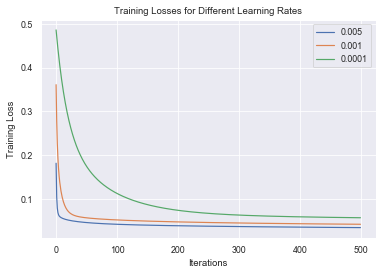

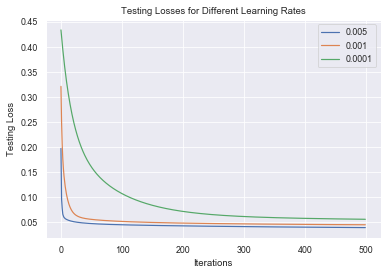

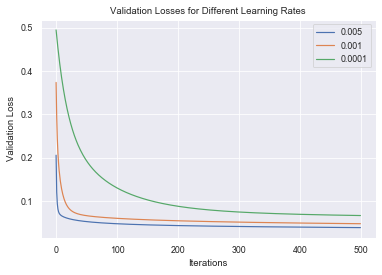

In [12]:
# Define parameters
error_tol = 1.0e-7
epochs = 500
alpha_list = [0.005, 0.001, 0.0001]

# Set up error tracking for plot
train_err = list()
test_err = list()
valid_error = list()

# Perform gradient descent for all alphas
for alpha in alpha_list:
    res = grad_descent_loss(W_initial, b_initial, X_train, Y_train, alpha, epochs, reg_param, error_tol, X_test, Y_test, 
                            X_validation, Y_validation)
    W_opt, b_opt, num_iterations, err_train, err_test, err_val = res[0], res[1], res[2], res[3], res[4], res[5]
    train_err.append(err_train)
    test_err.append(err_test)
    valid_error.append(err_val)

# Plot Training Losses
for e in train_err:
    plt.plot(e)
plt.title('Training Losses for Different Learning Rates')
plt.legend(alpha_list)
plt.ylabel('Training Loss')
plt.xlabel('Iterations')
plt.show()

# Plot Test Losses
for e in test_err:
    plt.plot(e)
plt.title('Testing Losses for Different Learning Rates')
plt.legend(alpha_list)
plt.ylabel('Testing Loss')
plt.xlabel('Iterations')
plt.show()

# Plot Validation Losses
for e in valid_error:
    plt.plot(e)
plt.title('Validation Losses for Different Learning Rates')
plt.legend(alpha_list)
plt.ylabel('Validation Loss')
plt.xlabel('Iterations')
plt.show()


### 4. Generalization

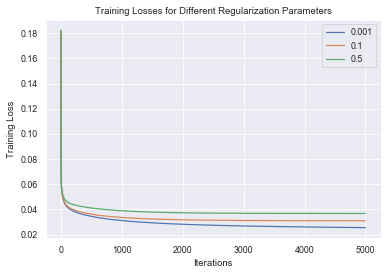

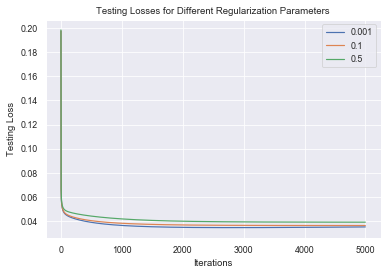

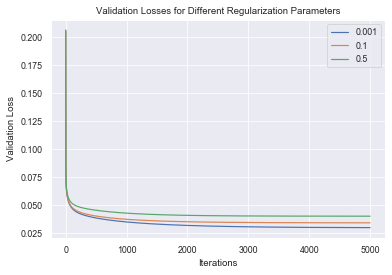

For regularization parameter value lambda = 0.001, final accuracy was: Training - 98.28571% Testing - 97.24138% Validation - 98.0%
For regularization parameter value lambda = 0.1, final accuracy was: Training - 98.02857% Testing - 97.24138% Validation - 98.0%
For regularization parameter value lambda = 0.5, final accuracy was: Training - 97.57143% Testing - 96.55172% Validation - 97.0%


In [13]:
# Define params
error_tol = 1.0e-7
epochs = 5000
reg_param_list = [0.001,0.1,0.5]
alpha = 0.005

# Set up variables for storing results
opt_weights = list()
opt_bias = list()

train_err = list()
test_err = list()
valid_error = list()

# Perform gradient descent, recording information
for reg_param in reg_param_list:
    res = grad_descent_loss(W_initial, b_initial, X_train, Y_train, alpha,\
                            epochs, reg_param, error_tol, X_test, Y_test, 
                            X_validation, Y_validation)
    W_opt, b_opt, num_iterations, err_train, err_test, err_val = res[0], res[1], res[2], res[3], res[4], res[5]
    opt_weights.append(W_opt)
    opt_bias.append(b_opt)
    train_err.append(err_train)
    test_err.append(err_test)
    valid_error.append(err_val)

# Plot errors
for e in train_err:
    plt.plot(e)
plt.title('Training Losses for Different Regularization Parameters')
plt.legend(reg_param_list)
plt.ylabel('Training Loss')
plt.xlabel('Iterations')
plt.show()

for e in test_err:
    plt.plot(e)
plt.title('Testing Losses for Different Regularization Parameters')
plt.legend(reg_param_list)
plt.ylabel('Testing Loss')
plt.xlabel('Iterations')
plt.show()

for e in valid_error:
    plt.plot(e)
plt.title('Validation Losses for Different Regularization Parameters')
plt.legend(reg_param_list)
plt.ylabel('Validation Loss')
plt.xlabel('Iterations')
plt.show()

# Calculate accuracy and print it
predictions = lambda x,w,b: np.rint(np.matmul(x,w) + b)
def correct_prediction_percentage(x,w,b,y):
    yhat = predictions(x,w,b)
    num_correct = np.sum(yhat == y)
    rate = num_correct/np.size(y)
    return np.round(100.0*rate, 5)

for i, val in enumerate(reg_param_list):
    train_acc = correct_prediction_percentage(X_train, opt_weights[i], opt_bias[i], Y_train)
    test_acc = correct_prediction_percentage(X_test, opt_weights[i], opt_bias[i], Y_test)
    valid_acc = correct_prediction_percentage(X_validation, opt_weights[i], opt_bias[i], Y_validation)
    print('For regularization parameter value lambda = ' + str(val) +
          ', final accuracy was: Training - ' + str(train_acc) + '% Testing - ' + 
          str(test_acc) + '% Validation - ' + str(valid_acc) + '%')

### 5. Comparing Batch GD with normal equation

Closed form equation: $W_{opt} = (X^TX)^{-1}X^TY$

In [14]:
import time

# Define params
error_tol = 1.0e-7
epochs = 5000
reg_param = 0.1
alpha = 0.005

# Calculate accuracy
predictions = lambda x,w,b: np.rint(np.matmul(x,w) + b)
def correct_prediction_percentage(x,w,b,y):
    yhat = predictions(x,w,b)
    num_correct = np.sum(yhat == y)
    rate = num_correct/np.size(y)
    return np.round(100.0*rate, 5)

# Calculate closed form weights
def optimal_weights_closed_form(x,y):
    return np.matmul(np.matmul(np.linalg.inv(np.matmul(np.transpose(x), x)), np.transpose(x)), y)

def format_for_output(a):
    return str(np.round(a,5))

cf_start = time.clock()
w_opt_cf = optimal_weights_closed_form(X_train, Y_train)
cf_time = format_for_output(time.clock() - cf_start)
cf_mse = format_for_output(MSE(w_opt_cf, b_initial, X_train, Y_train, reg_param))
cf_mse_t = format_for_output(MSE(w_opt_cf, b_initial, X_test, Y_test, reg_param))
cf_mse_val = format_for_output(MSE(w_opt_cf, b_initial, X_validation, Y_validation, reg_param))
cf_acc = format_for_output(correct_prediction_percentage(X_train, w_opt_cf, b_initial, Y_train))
cf_acc_t = format_for_output(correct_prediction_percentage(X_test, w_opt_cf, b_initial, Y_test))
cf_acc_val = format_for_output(correct_prediction_percentage(X_validation, w_opt_cf, b_initial, Y_validation))

# Calculate with Gradient Descent
gd_start = time.clock()
w_opt, b_opt, it = grad_descent(W_initial, b_initial, X_train, Y_train, alpha, epochs, reg_param, error_tol)
gd_time = format_for_output(time.clock() - gd_start)
gd_mse = format_for_output(MSE(w_opt, b_opt, X_train, Y_train, reg_param))
gd_mse_t = format_for_output(MSE(w_opt, b_opt, X_test, Y_test, reg_param))
gd_mse_val = format_for_output(MSE(w_opt, b_opt, X_validation, Y_validation, reg_param))
gd_acc = format_for_output(correct_prediction_percentage(X_train, w_opt, b_opt, Y_train))
gd_acc_t = format_for_output(correct_prediction_percentage(X_test, w_opt, b_opt, Y_test))
gd_acc_val = format_for_output(correct_prediction_percentage(X_validation, w_opt, b_opt, Y_validation))

print('Closed Form Solution:\nTime - ' + cf_time + '\nTraining MSE - ' + cf_mse + '\nTesting MSE - ' + cf_mse_t +
      '\nValidation MSE - ' + cf_mse_val + '\nTraining Accuracy - ' + cf_acc + '%' +
      '\nTesting Accuracy - ' + cf_acc_t + '%' + '\nValidation Accuracy - ' + cf_acc_val + '%')
print('Batch GD Solution:\nTime - ' + gd_time + '\nTraining MSE - ' + gd_mse + '\nTesting MSE - ' + gd_mse_t +
      '\nValidation MSE - ' + gd_mse_val + '\nTraining Accuracy - ' + gd_acc + '%' +
      '\nTesting Accuracy - ' + gd_acc_t + '%' + '\nValidation Accuracy - ' + gd_acc_val + '%')


Closed Form Solution:
Time - 0.46894
Training MSE - 0.90602
Testing MSE - 0.94966
Validation MSE - 0.9431
Training Accuracy - 98.42857%
Testing Accuracy - 91.72414%
Validation Accuracy - 94.0%
Batch GD Solution:
Time - 26.6525
Training MSE - 0.03094
Testing MSE - 0.03657
Validation MSE - 0.03427
Training Accuracy - 98.02857%
Testing Accuracy - 97.24138%
Validation Accuracy - 98.0%


When it comes to the training data, the Closed Form (CF) solution performs significantly better than Batch GD. While the MSE is higher the CF solution takes approximately 2% of the time to generate compared to Batch GD and performs more accurate classification (98.43% vs 98.03%) on the training data. However, when generalizing to unseen data sets (i.e. testing, validation sets), the closed form solution performs worse, with significant declines in accuracy. This makes sense as the closed form solution is fitted specifically to the training data set and is further from a generalized, optimal solution (as evidenced by its higher MSE value). Also, computing the closed form solution becomes more difficult with larger data sets due to the high computational requirements for solving the inverse of the $(X^TX)$ matrix.

## 2. Logistic Regression

### 1. Loss Function and Gradient

\begin{align*}
Let\ \hat{y} = \sigma(W^Tx + b)
&= \frac{1}{1+e^{-(W^Tx^{(n)}+b)}}
\end{align*}
\begin{align*}
L &= L_{D} + L_{W} \\
&= \sum_{n=1}^{N}\frac1N\left[ \underbrace{- y^{(n)}log\hat{y}(x^{(n)})}_{\alpha} - \underbrace{(1 - y^{(n)})log(1 - \hat{y}(x^{(n)}))}_{\beta} \right] + \frac\lambda2\lvert\lvert W\rvert\rvert_{2}^{2}\\
\end{align*}
\begin{equation*}
By\ inspection\ of\ weight\ decay\ loss,\ \frac{\partial L_w}{\partial b} = 0, \frac{\partial L_w}{\partial w} = \lambda w.
\end{equation*}
#### With respect to weights
\begin{equation*}
\frac{\partial \alpha}{\partial W} = \frac{-x^{(n)}y^{(n)}e^{-(W^Tx^{(n)}+b)}}{1+e^{-(W^Tx^{(n)}+b)}}\ \ \ \ \frac{\partial \beta}{\partial W} = (1-y^{(n)})\frac{-x^{(n)}}{1+e^{-(W^Tx^{(n)}+b)}}
\end{equation*}
\begin{align*}
\frac{\partial L}{\partial W} &= \frac{1}{N}\sum_{n=1}^{N}\left[\frac{\partial \alpha}{\partial W} - \frac{\partial \beta}{\partial W}\right] + \lambda W\\
&=\frac{1}{N}\sum_{n=1}^{N}\left[\frac{-x^{(n)}y^{(n)}e^{-(W^Tx^{(n)}+b)} + (1-y^{(n)})(x^{(n)})}{1+e^{-(W^Tx^{(n)}+b)}}\right]+ \lambda W\\
&=\frac{1}{N}\sum_{n=1}^{N}\left[x^{(n)}\left(\frac{-y^{(n)}(1+e^{-(W^Tx^{(n)}+b)}) + 1}{1+e^{-(W^Tx^{(n)}+b)}}\right)\right]+ \lambda W\\
&=\frac{1}{N}\sum_{n=1}^{N}\left[x^{(n)}(-y^{(n)} + \hat{y}^{(n)})\right]+ \lambda W\\
&=\frac{1}{N}\left[X^T(\hat{Y}-Y)\right]+ \lambda W
\end{align*}

#### With respect to bias
\begin{equation*}
\frac{\partial \alpha}{\partial b} = \frac{-y^{(n)}e^{-(W^Tx^{(n)}+b)}}{1+e^{-(W^Tx^{(n)}+b)}}\ \ \ \ \frac{\partial \beta}{\partial b} = \frac{-(1-y^{(n)})}{1+e^{-(W^Tx^{(n)}+b)}}
\end{equation*}
\begin{align*}
\frac{\partial L}{\partial b} &= \frac{1}{N}\sum_{n=1}^{N}\left[\frac{\partial \alpha}{\partial b} - \frac{\partial \beta}{\partial b}\right]\\
&=\frac{1}{N}\sum_{n=1}^{N}\left[\frac{-y^{(n)}e^{-(W^Tx^{(n)}+b)} + (1-y^{(n)})}{1+e^{-(W^Tx^{(n)}+b)}}\right]\\
&=\frac{1}{N}\sum_{n=1}^{N}\left[x^{(n)}\left(\frac{-y^{(n)}(1+e^{-(W^Tx^{(n)}+b)}) + 1}{1+e^{-(W^Tx^{(n)}+b)}}\right)\right]\\
&=\frac{1}{N}\sum_{n=1}^{N}\left[(-y^{(n)} + \hat{y}^{(n)})\right]\\
\end{align*}

In [15]:
def crossEntropyLoss(W, b, x, y, reg):
    y_hat_sigmoid_func = 1 / (1 + np.exp(-np.matmul(x, W) - b))
    cross_entropy_loss = (-1) * np.matmul(np.transpose(y), np.log(y_hat_sigmoid_func)) \
                         - np.matmul(np.transpose(1 - y), np.log(1 - y_hat_sigmoid_func))
    cross_entropy_loss *= (1 / np.size(y))

    weight_decay_loss = 0.5 * reg * np.square(np.linalg.norm(W))

    return cross_entropy_loss.item() + weight_decay_loss


In [16]:
def gradCE(W, b, x, y, reg):
    y_hat_sigmoid_func = 1 / (1 + np.exp(-np.matmul(x, W) - b))

    grad_wrt_weights = (1 / np.size(y)) * np.matmul(np.transpose(x), (y_hat_sigmoid_func - y)) + reg * W
    grad_wrt_bias = (1 / np.size(y)) * np.sum(y_hat_sigmoid_func - y)

    return grad_wrt_bias, grad_wrt_weights

### 2. Learning

In [18]:
def grad_descent(W, b, x, y , alpha, epochs, reg, error_tol, lossType="MSE"):
    iters = 0
    for i in range (0, epochs):
        iters += 1
        if lossType == "MSE":
            gradient = grad_MSE(W,b,x,y,reg)
        elif lossType == "CE":
            gradient = gradCE(W,b,x,y,reg)
            
        b = b - alpha*gradient[0]
        W = W - alpha*gradient[1]
        iteration_error = np.abs(alpha*(gradient[0] + np.sum(gradient[1])))
        if iteration_error <= error_tol:
            break
    return W, b, iters

In [19]:
# Gradient Descent with loss and accuracy calculations
def grad_descent_loss_accuracy(W, b, x, y , alpha, epochs, reg, error_tol, x_test, y_test, x_validation, y_validation, lossType="MSE"):
    iters = 0
    training_losses, testing_losses, validation_losses = np.zeros(epochs, dtype=np.float64), \
                                                         np.zeros(epochs, dtype=np.float64), \
                                                         np.zeros(epochs, dtype=np.float64)
    training_accuracy, testing_accuracy, validation_accuracy = np.zeros(epochs, dtype=np.float64), \
                                                         np.zeros(epochs, dtype=np.float64), \
                                                         np.zeros(epochs, dtype=np.float64)
    for i in range (0, epochs):
        iters += 1
        
        if lossType == "MSE":
            gradient = grad_MSE(W,b,x,y,reg)
            
            b = b - alpha*gradient[0]
            W = W - alpha*gradient[1]
            
            # store the loss data for each iter
            np.put(training_losses, i, MSE(W,b,x,y,reg))
            np.put(testing_losses, i, MSE(W,b,x_test,y_test,reg))
            np.put(validation_losses, i, MSE(W,b,x_validation,y_validation,reg))
            
            # Calculate the prediction
            pred = np.rint(np.matmul(x,W) + b)
            pred_test = np.rint(np.matmul(x_test,W) + b)
            pred_val = np.rint(np.matmul(x_validation,W) + b)
            
        elif lossType == "CE":
            gradient = gradCE(W,b,x,y,reg)
            
            b = b - alpha*gradient[0]
            W = W - alpha*gradient[1]

            # store the loss data for each iter
            np.put(training_losses, i, crossEntropyLoss(W,b,x,y,reg))
            np.put(testing_losses, i, crossEntropyLoss(W,b,x_test,y_test,reg))
            np.put(validation_losses, i, crossEntropyLoss(W,b,x_validation,y_validation,reg))
        
            # Calculate the prediction
            pred = np.rint(1 / (1 + np.exp(-np.matmul(x, W) - b)))
            pred_test = np.rint(1 / (1 + np.exp(-np.matmul(x_test, W) - b)))
            pred_val = np.rint(1 / (1 + np.exp(-np.matmul(x_validation, W) - b)))
            
        # Store the accuracy for each iter
        np.put(training_accuracy, i, np.sum(y == pred)/np.size(y))
        np.put(testing_accuracy, i, np.sum(y_test == pred_test)/np.size(y_test))
        np.put(validation_accuracy, i, np.sum(y_validation == pred_val)/np.size(y_validation))
        
        iteration_error = np.abs(alpha*(gradient[0] + np.sum(gradient[1])))
        if iteration_error <= error_tol:
            break
    return W, b, iters, training_losses, testing_losses, validation_losses, training_accuracy, testing_accuracy, validation_accuracy

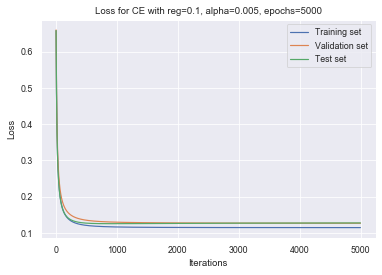

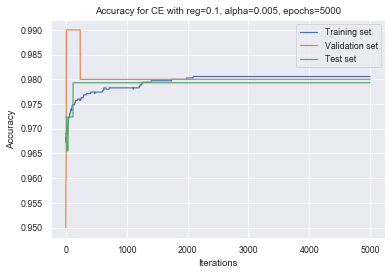

In [102]:
error_tol = 1.0e-7
epochs = 5000
reg_param1 = 0.1
alpha = 0.005

res = grad_descent_loss_accuracy(W_initial, b_initial, X_train, Y_train, alpha, epochs, reg_param1, error_tol, \
                                 X_test, Y_test, X_validation, Y_validation, lossType="CE")

W_opt, b_opt, num_iterations = res[0], res[1], res[2]
loss_train, loss_test, loss_val = res[3], res[4], res[5]
acc_train, acc_test, acc_val = res[6], res[7], res[8]


dataset_list = ["Training set", "Validation set", "Test set"]
plt.plot(loss_train)
plt.plot(loss_val)
plt.plot(loss_test)
plt.title('Loss for CE with reg=0.1, alpha=0.005, epochs=5000')
plt.legend(dataset_list)
plt.ylabel('Loss')
plt.xlabel('Iterations')
plt.show()

plt.plot(acc_train)
plt.plot(acc_val)
plt.plot(acc_test)
plt.title('Accuracy for CE with reg=0.1, alpha=0.005, epochs=5000')
plt.legend(dataset_list)
plt.ylabel('Accuracy')
plt.xlabel('Iterations')
plt.show()

### 3. Comparison to Linear Regression

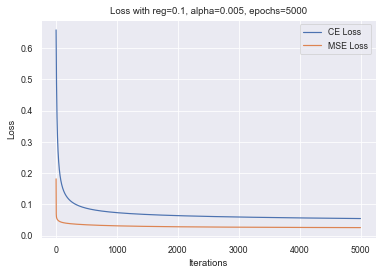

In [21]:
error_tol = 1.0e-7
epochs = 5000
reg_param1 = 0
alpha = 0.005

res_ce = grad_descent_loss_accuracy(W_initial, b_initial, X_train, Y_train, alpha, epochs, reg_param1, error_tol, \
                                 X_test, Y_test, X_validation, Y_validation, lossType="CE")
loss_train = res_ce[3]


res_mse = grad_descent_loss_accuracy(W_initial, b_initial, X_train, Y_train, alpha, epochs, reg_param1, error_tol, \
                                 X_test, Y_test, X_validation, Y_validation, lossType="MSE")
loss_train_mse = res_mse[3]

dataset_list = ["CE Loss", "MSE Loss"]
plt.plot(loss_train)
plt.plot(loss_train_mse)
plt.title('Loss with reg=0.1, alpha=0.005, epochs=5000')
plt.legend(dataset_list)
plt.ylabel('Loss')
plt.xlabel('Iterations')
plt.show()

Based on the graph, cross entropy converges slower than MSE.

## Part 3

### 1. Building the Computational Graph

In [24]:
import tensorflow as tf

def buildGraph(loss="MSE", b1=0.9, b2=0.999, ep=1e-08):
    tf.set_random_seed(421)
    b = tf.Variable(0, dtype=tf.float32)
    w = tf.Variable(tf.truncated_normal(shape=[784, 1], stddev=0.5, seed=1, dtype=tf.float32))
    
    x = tf.placeholder(dtype=tf.float32)
    y = tf.placeholder(dtype=tf.float32)
    reg_param = tf.placeholder(dtype=tf.float32)
    
    predictions = tf.math.add(tf.matmul(x,w), b)
    
    loss_func = reg_param*tf.nn.l2_loss(w) # no mult. by 0.5 as it is implicit in l2_loss
    if loss == "MSE":
        loss_func += tf.losses.mean_squared_error(labels=y, predictions=predictions)
        correct_predictions = tf.equal(y, tf.round(predictions))
    elif loss == "CE":
        loss_func += tf.reduce_mean(tf.losses.sigmoid_cross_entropy(multi_class_labels=y,logits=predictions))
        correct_predictions = tf.equal(y, tf.round(tf.sigmoid(predictions)))

    accuracy = tf.reduce_mean(tf.cast(correct_predictions, tf.float32))
    optimizer = tf.train.AdamOptimizer(learning_rate=0.001, beta1=b1, beta2=b2, epsilon=ep).minimize(loss_func)
    return w, b, x, y, reg_param, loss_func, optimizer, accuracy

### 2. Implementing Stochastic Gradient Descent

In [25]:
def SGD(epochs, reg, error_tol, batch_size=500, lossType="MSE", beta1=0.9, beta2=0.999, epsilon=1e-08, plot=True):
    sess = tf.Session()
    
    w, b, x, y, reg_param, loss, optimizer, accuracy = buildGraph(loss=lossType, b1=beta1, b2=beta2, ep=epsilon)
        
    init = tf.global_variables_initializer()
    sess.run(init)
    
    training_losses, testing_losses, validation_losses = [], [], []
    training_accuracy, testing_accuracy, validation_accuracy = [], [], []
    
    trainData, validData, testData, trainTarget, validTarget, testTarget = loadData()

    # Training Data
    X_train = np.reshape(trainData, (3500,784))
    Y_train = np.array(trainTarget)

    # Test Data
    X_test = np.reshape(testData, (145,784))
    Y_test = np.array(testTarget)

    # Validation Data
    X_validation = np.reshape(validData, (100,784))
    Y_validation = np.array(validTarget)
    
    num_of_batches = np.size(Y_train) / batch_size
    
    for i in range (0, epochs):
        # shuffle indexes for the data array
        random_indexes = np.random.choice(np.size(Y_train), size=np.size(Y_train), replace=False)
        # split them into batches
        batch_indexes = np.split(random_indexes, num_of_batches)
        for batch in batch_indexes:
            x_batch = X_train[batch]
            y_batch = Y_train[batch]

            # Calculate the gradient descent
            sess.run(optimizer, feed_dict={x: x_batch, y:y_batch, reg_param: reg})

        # Calculate the losses for the whole data after the epoch
        training_losses.append(sess.run(loss, feed_dict={x: X_train, y:Y_train, reg_param: reg}))
        validation_losses.append(sess.run(loss, feed_dict={x: X_validation, y:Y_validation, reg_param: reg}))
        testing_losses.append(sess.run(loss, feed_dict={x: X_test, y:Y_test, reg_param: reg}))
        
        # Calculate the accuracy for the whole data after the epoch
        training_accuracy.append(sess.run(accuracy, feed_dict={x: X_train, y:Y_train}))
        validation_accuracy.append(sess.run(accuracy, feed_dict={x: X_validation, y:Y_validation}))
        testing_accuracy.append(sess.run(accuracy, feed_dict={x: X_test, y:Y_test}))
       
    sess.close()
    
    if plot:
        # Plot the loss
        plt.plot(training_losses, 'r--', label="Training Loss")
        plt.plot(validation_losses, 'b--', label="Validation Loss")
        plt.plot(testing_losses, 'g--', label="Test Loss")
        plt.legend()
        plt.title('%s Loss for batch size of %d'%(lossType, batch_size))
        plt.ylabel('Loss')
        plt.xlabel('Iterations')
        plt.show()

        # Plot the accuracy
        plt.plot(training_accuracy, 'r--', label="Training Accuracy")
        plt.plot(validation_accuracy, 'b--', label="Validation Accuracy")
        plt.plot(testing_accuracy, 'g--', label="Test Accuracy")
        plt.legend()
        plt.title('%s Accuracy for batch size of %d'%(lossType, batch_size))
        plt.ylabel('Accuracy')
        plt.xlabel('Iterations')
        plt.show()
    
    print("Final training accuracy %.4f"%training_accuracy[epochs-1])
    print("Final validation accuracy %.4f"%validation_accuracy[epochs-1])
    print("Final testing accuracy %.4f"%testing_accuracy[epochs-1])



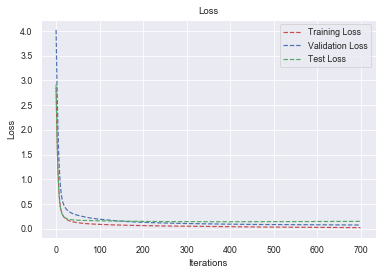

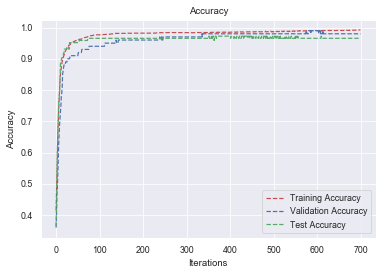

Final training accuracy 0.992
Final validation accuracy 0.980
Final testing accuracy 0.966


In [20]:
epochs = 700
reg_param = 0
error_tol = 1.0e-7
SGD(epochs, reg_param, error_tol, batch_size=500, lossType="CE")

### 3. Batch Size Investigation

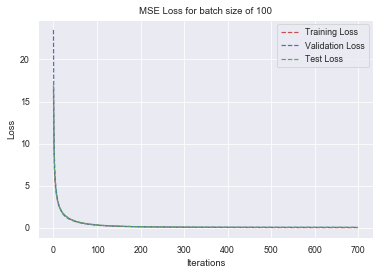

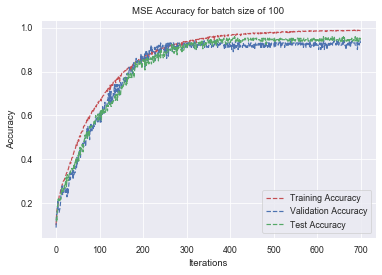

Final training accuracy 0.987
Final validation accuracy 0.930
Final testing accuracy 0.945


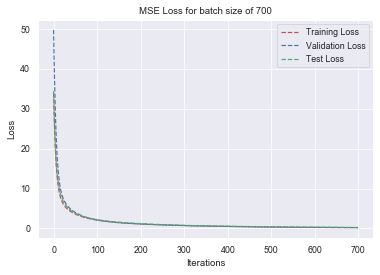

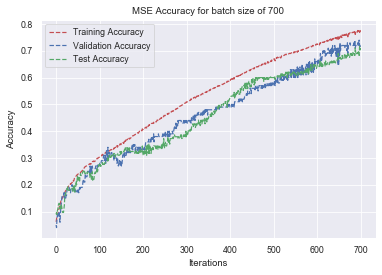

Final training accuracy 0.772
Final validation accuracy 0.710
Final testing accuracy 0.710


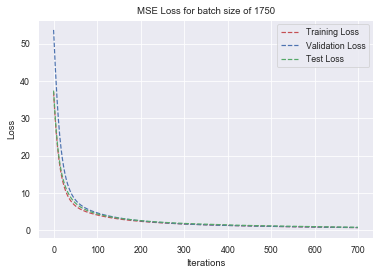

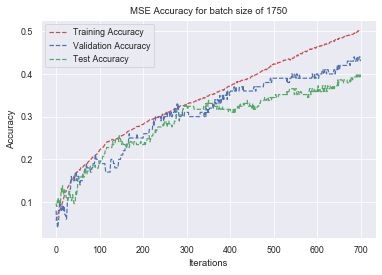

Final training accuracy 0.503
Final validation accuracy 0.430
Final testing accuracy 0.400


In [26]:
epochs = 700
SGD(epochs, reg_param, error_tol, batch_size=100, lossType="MSE")
SGD(epochs, reg_param, error_tol, batch_size=700, lossType="MSE")
SGD(epochs, reg_param, error_tol, batch_size=1750, lossType="MSE")

For MSE, a smaller batch size leads to faster convergence, and a significantly better accuracy over 700 iterations. We suspect that this is because a smaller batch size allows for more (smaller) updates per epoch at a time when the weights are significantly incorrect, allowing the accuracy to improve more in a smaller number of iterations.

Note: As Cross Entropy Loss Investigation (#5) refers to section 3.1.2 and 3.1.4, they were placed next to it for convenience.<br>
__#4 is found below.__
### 5. Cross Entropy Loss Investigation

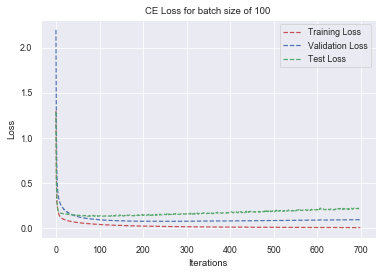

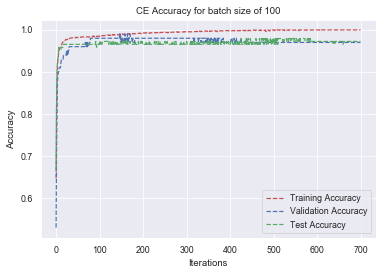

Final training accuracy 1.000
Final validation accuracy 0.970
Final testing accuracy 0.972


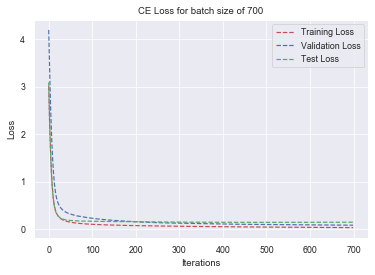

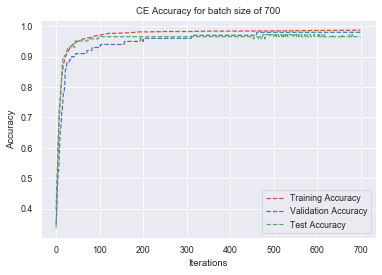

Final training accuracy 0.988
Final validation accuracy 0.980
Final testing accuracy 0.966


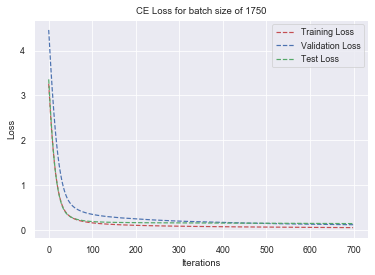

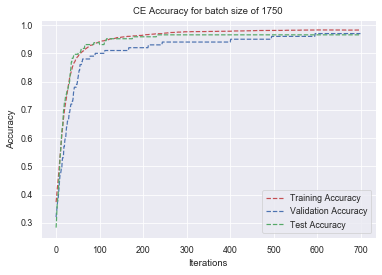

Final training accuracy 0.983
Final validation accuracy 0.970
Final testing accuracy 0.966


In [27]:
SGD(epochs, reg_param, error_tol, batch_size=100, lossType="CE")
SGD(epochs, reg_param, error_tol, batch_size=700, lossType="CE")
SGD(epochs, reg_param, error_tol, batch_size=1750, lossType="CE")

The models are similar in that the convergence is faster for the smaller batch size, and the accuracy of the classification model to unseen datasets (i.e. validation, testing) are better for the smaller size. However, the cross entropy accuracy is significantly better in terms of final classification accuracy for all batch sizes, by a significant margin.

### 4. Hyperparameter Investigation 

In [ ]:
SGD(epochs, reg_param, error_tol, batch_size=500, lossType="MSE", beta1=0.95, plot=False)
SGD(epochs, reg_param, error_tol, batch_size=500, lossType="MSE", beta1=0.99, plot=False)
SGD(epochs, reg_param, error_tol, batch_size=500, lossType="MSE", beta2=0.99, plot=False)
SGD(epochs, reg_param, error_tol, batch_size=500, lossType="MSE", beta2=0.9999, plot=False)
SGD(epochs, reg_param, error_tol, batch_size=500, lossType="MSE", epsilon=1e-09, plot=False)
SGD(epochs, reg_param, error_tol, batch_size=500, lossType="MSE", epsilon=1e-04, plot=False)

| Accuracy   | $\beta_1 = 0.95$ | $\beta_1 = 0.99$ | $\beta_2 = 0.99$ | $\beta_2 = 0.9999$ | $\epsilon = 1e^{-09}$ | $\epsilon = 1e^{-04}$ |
| ---------- | ---------------- | ---------------- | ---------------- | ------------------ | --------------------- | --------------------- |
| Training   | 0.869            | 0.862            | 0.937            | 0.771              | 0.862                 |0.861|
| Validation | 0.870            | 0.860            | 0.930            | 0.720              | 0.860                 |0.860|
| Testing    | 0.821            | 0.841            | 0.903            | 0.697              | 0.821                 |0.821|



In [ ]:
SGD(epochs, reg_param, error_tol, batch_size=500, lossType="CE", beta1=0.95, plot=False)
SGD(epochs, reg_param, error_tol, batch_size=500, lossType="CE", beta1=0.99, plot=False)
SGD(epochs, reg_param, error_tol, batch_size=500, lossType="CE", beta2=0.99, plot=False)
SGD(epochs, reg_param, error_tol, batch_size=500, lossType="CE", beta2=0.9999, plot=False)
SGD(epochs, reg_param, error_tol, batch_size=500, lossType="CE", epsilon=1e-09, plot=False)
SGD(epochs, reg_param, error_tol, batch_size=500, lossType="CE", epsilon=1e-04, plot=False)

| Accuracy   | $\beta_1 = 0.95$ | $\beta_1 = 0.99$ | $\beta_2 = 0.99$ | $\beta_2 = 0.9999$ | $\epsilon = 1e^{-09}$ | $\epsilon = 1e^{-04}$ |
| ---------- | ---------------- | ---------------- | ---------------- | ------------------ | --------------------- | --------------------- |
| Training   | 0.992       | 0.992       | 0.997       | 0.987         | 0.992            |0.992|
| Validation | 0.980       | 0.980       | 0.970       | 0.980       | 0.980            |0.980|
| Testing    | 0.966       | 0.966       | 0.966       | 0.966         | 0.966            |0.966|

From the two charts, for both MSE and CE the results are fairly similar with respect to the changes produced by tuning the hyperparameters. Changes to $\beta_1$ and $\epsilon$ have negligible impact on the results according to our data. Increases to $\beta_2$ have a significant negative impact on MSE accuracy and a minor negative impact on CE training accuracy. According to the Tensorflow documentation, the beta hyperparameters control the exponential decay rates for the 1st and 2nd moment estimates respectively, while the epsilon is a constant for numerical stability. They are used in accordance with the equations listed below.

<img src="files/hyperparam.png">

### 5. Cross Entropy Loss Investigation - (See Above)

### 6. Comparison against Batch GD

SGD with ADAM performs significantly better than the Batch GD equation, converging more quickly to a higher accuracy. The SGD with ADAM graphs show a little more "noise" in the accuracy (i.e. it has a tendency to make "sharper" movements up and down, resulting in some jagged portions rather than being a perfectly smooth curve), as we are updating based on randomly drawn batches of the data set.